In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import torch
from dotenv import load_dotenv
from monai.transforms import LoadImaged, Compose, Resized, EnsureChannelFirstd

# Add the project source to the Python path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import your custom transforms
from src.data.transforms import RidgeletTransformd, HaarTransformd

# Set notebook style
plt.style.use('seaborn-v0_8-whitegrid')
print("Setup complete.")

Setup complete.


In [2]:
# Load environment variables
load_dotenv(dotenv_path='../.env')
IMAGE_ROOT_DIR = os.getenv("MIMIC_CXR_P_FOLDERS_PATH")
PROJECT_DATA_FOLDER_PATH = os.getenv("PROJECT_DATA_FOLDER_PATH")

if not all([IMAGE_ROOT_DIR, PROJECT_DATA_FOLDER_PATH]):
    raise ValueError("Please ensure all required environment variables are set.")

# --- 1. Load data and select a sample with a fracture ---
val_csv_path = os.path.join(PROJECT_DATA_FOLDER_PATH, "splits", "split_2000", "validation.csv")
df_val = pd.read_csv(val_csv_path)

df_fractures = df_val[df_val['fracture'] == 1]
if df_fractures.empty:
    raise ValueError("No fracture cases found in the validation split.")

# Get image path
sample_record = df_fractures.iloc[0]
subject_id = str(int(sample_record['subject_id']))
study_id = str(int(sample_record['study_id']))
dicom_id = str(sample_record['dicom_id'])
image_relative_path = os.path.join(f"p{subject_id[:2]}", f"p{subject_id}", f"s{study_id}", f"{dicom_id}.jpg")
full_image_path = os.path.join(IMAGE_ROOT_DIR, image_relative_path)

sample_dict = {"image": full_image_path}
print(f"Successfully located image with a fracture:\n{full_image_path}")

Successfully located image with a fracture:
E:/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/files\p19\p19175595\s52445151\468a1675-344a56da-7cf12651-0344086a-8454a87a.jpg


In [3]:
# --- Configuration for Visualization ---
SQUARE_SIZE = 512
THRESHOLD_RATIO = 0.0 # Using 10% thresholding on details

# --- Base Preprocessing ---
base_pipeline = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Resized(keys=["image"], spatial_size=(SQUARE_SIZE, SQUARE_SIZE)),
])
preprocessed_dict = base_pipeline(sample_dict)
original_image_tensor = preprocessed_dict['image']

# --- Define and Apply Haar Transform Configurations ---

# Config 1: Default (Approximation + All Details)
haar_config_1 = {
    "levels": 2,
    "details_to_keep": ["LL", "HL", "LH", "HH"],
    "threshold_ratio": THRESHOLD_RATIO
}
haar_transformer_1 = HaarTransformd(keys=["image"], output_key="image_haar_1", **haar_config_1)
result_1 = haar_transformer_1(preprocessed_dict.copy())

# Config 2: Horizontal & Vertical details ONLY (with sharpening)
haar_config_2 = {
    "levels": 1,
    "details_to_keep": ["HL", "LH", "HH"],
    "threshold_ratio": THRESHOLD_RATIO,
    "unsharp_amount": 1.0,  # <-- Corrected parameter
    "unsharp_sigma": 1.5    # <-- Corrected parameter
}
haar_transformer_2 = HaarTransformd(keys=["image"], output_key="image_haar_2", **haar_config_2)
result_2 = haar_transformer_2(preprocessed_dict.copy())

# Config 3: Horizontal & Vertical details ONLY (no sharpening)
haar_config_3 = {
    "levels": 1,
    "details_to_keep": ["HL", "LH", "HH"],
    "threshold_ratio": THRESHOLD_RATIO
}
haar_transformer_3 = HaarTransformd(keys=["image"], output_key="image_haar_3", **haar_config_3)
result_3 = haar_transformer_3(preprocessed_dict.copy())

# Config 4: Approximation ONLY (3 levels)
haar_config_4 = {
    "levels": 3,
    "details_to_keep": ["LL"],
    "threshold_ratio": 0.0
}
haar_transformer_4 = HaarTransformd(keys=["image"], output_key="image_haar_4", **haar_config_4)
result_4 = haar_transformer_4(preprocessed_dict.copy())

print("All transform configurations applied successfully.")

All transform configurations applied successfully.


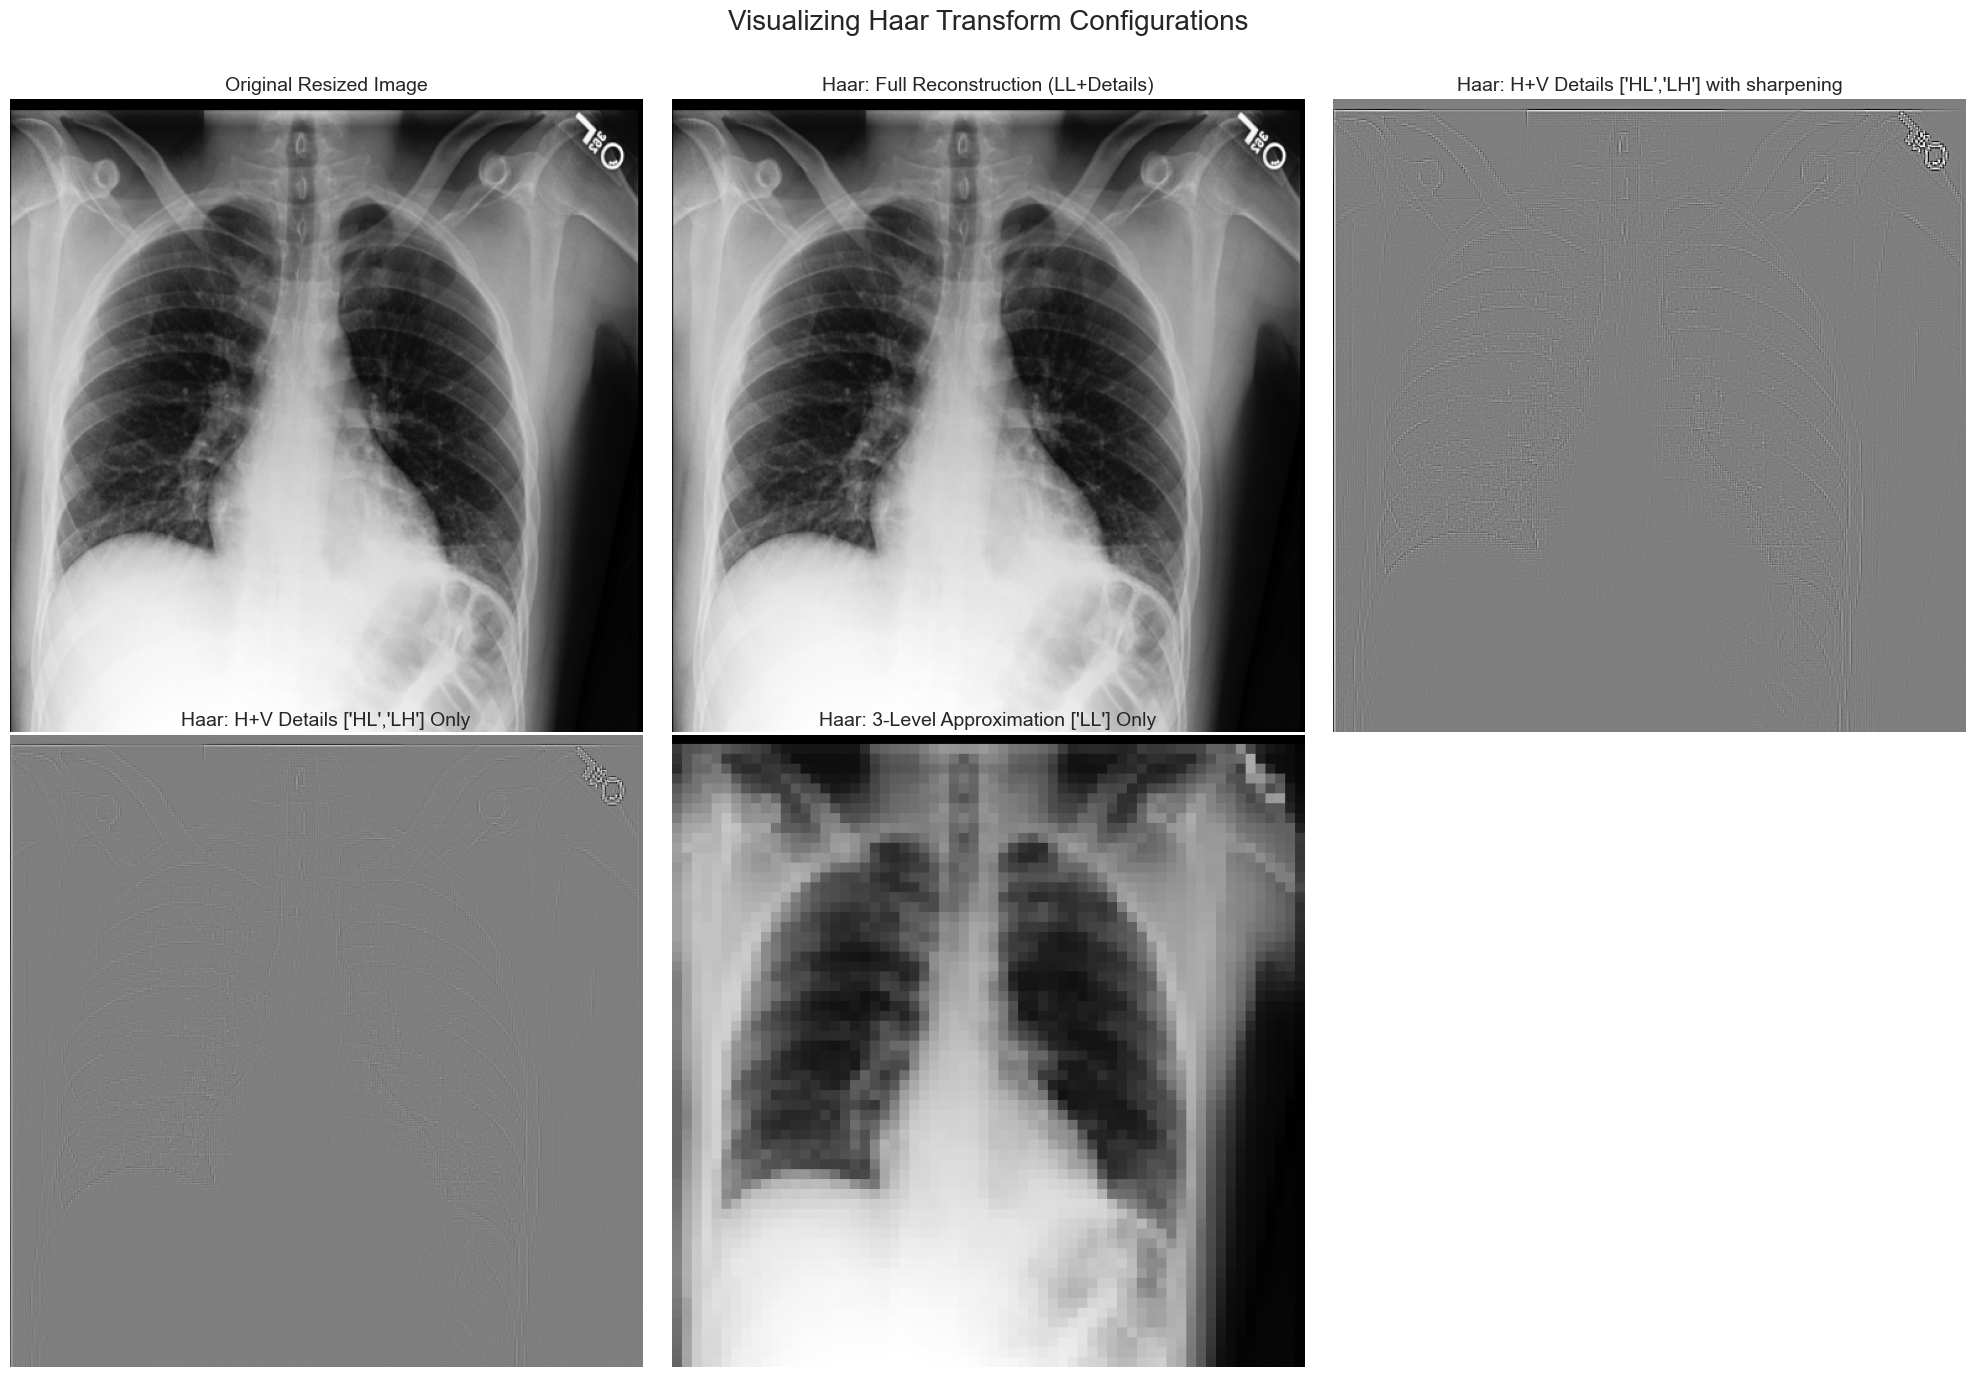

In [4]:
# %%
# --- Prepare Tensors for Plotting ---
original_np = original_image_tensor.squeeze().numpy()
haar_1_np = result_1['image_haar_1'].squeeze().numpy()
haar_2_np = result_2['image_haar_2'].squeeze().numpy()
haar_3_np = result_3['image_haar_3'].squeeze().numpy()
haar_4_np = result_4['image_haar_4'].squeeze().numpy()

# --- Create a figure to display all results ---
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle("Visualizing Haar Transform Configurations", fontsize=20)

axes[0, 0].imshow(original_np.T, cmap='gray')
axes[0, 0].set_title('Original Resized Image', fontsize=14)
axes[0, 0].axis('off')

axes[0, 1].imshow(haar_1_np.T, cmap='gray')
axes[0, 1].set_title(f"Haar: Full Reconstruction (LL+Details)", fontsize=14)
axes[0, 1].axis('off')

axes[0, 2].imshow(haar_2_np.T, cmap='gray')
axes[0, 2].set_title(f"Haar: H+V Details ['HL','LH'] with sharpening", fontsize=14)
axes[0, 2].axis('off')

axes[1, 0].imshow(haar_3_np.T, cmap='gray')
axes[1, 0].set_title(f"Haar: H+V Details ['HL','LH'] Only", fontsize=14)
axes[1, 0].axis('off')

axes[1, 1].imshow(haar_4_np.T, cmap='gray')
axes[1, 1].set_title(f"Haar: 3-Level Approximation ['LL'] Only", fontsize=14)
axes[1, 1].axis('off')

axes[1, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()